In [1]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

In [2]:
# define classes and data structures for code formatting
@dataclass
class Gaussian:
    mean: np.ndarray
    cov: np.ndarray

@dataclass
class Observations:
    times: np.ndarray
    obs_ind: np.ndarray
    obs: np.ndarray
    names: List[str]

@dataclass
class KFTracker:
    means: np.ndarray
    covs: np.ndarray
    stds: np.ndarray

In [3]:
# define the non-linear motion and the observation model
def motion_model(state, dt):
    g = 9.8  # gravity
    return np.array([
        state[0] + state[1] * dt,
        state[1] - g * np.sin(state[0]) * dt
    ])

def observation_model(state):
    return np.array([np.sin(state[0])])

In [4]:
# generate sigma points for UKF implementation
def sigma_points(X: Gaussian, alpha: float, kappa: float):
    n = X.mean.shape[0]
    lambda_ = alpha**2 * (n + kappa) - n

    try:
        L = np.linalg.cholesky((n + lambda_) * X.cov)
    except np.linalg.LinAlgError:
        # Add small regularization if cholesky decomposition fails
        L = np.linalg.cholesky((n + lambda_) * X.cov + 1e-8 * np.eye(n))

    sigma_pts = [X.mean]
    for i in range(n):
        sigma_pts.append(X.mean + L[i])
        sigma_pts.append(X.mean - L[i])

    return np.array(sigma_pts)

In [5]:
def gh_oned(num_pts=2):
    """Gauss-hermite quadrature in 1D"""
    A = np.zeros((num_pts, num_pts))
    for ii in range(num_pts):
        #print("ii ", ii, ii==0, ii==(order-1))
        row = ii+1
        if ii == 0:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
        elif ii == (num_pts-1):
            A[ii-1, ii] = np.sqrt(ii)
        else:
            A[ii, ii+1] = np.sqrt(row)
            A[ii+1, ii] = np.sqrt(row)
    pts, evec = np.linalg.eig(A)
    devec = np.dot(evec.T, evec)
    wts = evec[0,:]**2

    return pts, wts

def tensorize(nodes):
    """Tensorize nodes to obtain twod"""
    n1d = nodes.shape[0]
    twodnodes = np.zeros((n1d*n1d, 2))
    ind = 0
    for ii in range(n1d):
        for jj in range(n1d):
            twodnodes[ind, :] = np.array([nodes[ii], nodes[jj]])
            ind +=1
    return twodnodes

def gauss_hermite(dim, num_pts=2):
    """Gauss-hermite quadrature in 2D"""
    assert dim == 2, "Tensorize only implemented for di   m=2"
    pts, weights = gh_oned(num_pts)
    ptsT = tensorize(pts)
    weightsT = tensorize(weights)
    weightsT = np.prod(weightsT, axis=1)
    return ptsT, weightsT

In [6]:
# gauss-hermite kalman filter main loop
def gauss_hermit_kalman_filter(data: Observations, X: Gaussian, xi: Gaussian, eta: Gaussian, m: int) -> KFTracker:

    num_steps = data.times.shape[0]
    d = X.mean.shape[0]
    dt = data.times[1] - data.times[0]

    mean_store = np.zeros((num_steps, d))
    mean_store[0, :] = np.copy(X.mean)

    cov_store = np.zeros((num_steps, d, d))
    cov_store[0, :, :] = np.copy(X.cov)

    std_store = np.zeros((num_steps, d))
    std_store[0, :] = np.sqrt(np.diag(cov_store[0, :, :]))

    Xnext = X
    on_obs = 0

    # sigma points are (9, 2)
    # weights are (9, )
    # singel sigma point is (2,)
    # single weight is (), just float

    for k in range(1, num_steps):

        sigma_pts, wghts = gauss_hermite(d, num_pts=m)

        L = np.linalg.cholesky(xi.cov)
        sigma_pts = Xnext.mean + np.sqrt(2)*sigma_pts @ L

        n = wghts.shape[0]

        # Propagate sigma points
        propagated_pts = np.array([motion_model(pt, dt) for pt in sigma_pts]) # shape (9, 2)

        # Predict mean and covariance
        pred_mean = np.sum(wghts[:, np.newaxis] * propagated_pts, axis=0) # shape (2, )
        pred_cov = np.sum(wghts[:, np.newaxis, np.newaxis] *
                          [(pt - pred_mean).reshape(-1, 1) @ (pt - pred_mean).reshape(1, -1)
                           for pt in propagated_pts], axis=0) + xi.cov

        # Update step
        if on_obs < data.obs_ind.shape[0] and k == data.obs_ind[on_obs]:
            y = data.obs[on_obs]

            # Propagate sigma points through observation model
            obs_pts = np.array([observation_model(pt) for pt in propagated_pts])

            # Predict measurement
            pred_y = np.sum(wghts[:, np.newaxis] * obs_pts, axis=0)

            S = np.sum(wghts[:, np.newaxis, np.newaxis] *
                       [(pt - pred_y).reshape(-1, 1) @ (pt - pred_y).reshape(1, -1)
                        for pt in obs_pts], axis=0) + eta.cov

            # Calculate cross-covariance
            cross_cov = np.sum(wghts[:, np.newaxis, np.newaxis] *
                               [(propagated_pts[i] - pred_mean).reshape(-1, 1) @
                                (obs_pts[i] - pred_y).reshape(1, -1)
                                for i in range(n)], axis=0)

            # Kalman gain
            K = cross_cov @ np.linalg.inv(S)

            # Update state estimate
            Xnext.mean = pred_mean + K @ (y - pred_y)
            Xnext.cov = pred_cov - K @ cross_cov.T #S @ K.T

            on_obs += 1
        else:
            Xnext.mean = pred_mean
            Xnext.cov = pred_cov

        mean_store[k] = Xnext.mean
        cov_store[k] = Xnext.cov
        std_store[k] = np.sqrt(np.diag(Xnext.cov))

    return KFTracker(mean_store, cov_store, std_store)

In [7]:
# generate true and observed data for simulations
def generate_data(times, N, dt, obs_freq, x0, R):
    g = 9.8
    xout = np.zeros((N, 2))
    xout[0] = x0
    obs_ind = np.arange(obs_freq, N, obs_freq)
    num_obs = obs_ind.shape[0]
    yout = np.zeros(num_obs)

    for i in range(1, N):
        xout[i] = motion_model(xout[i-1], dt)

    for i, idx in enumerate(obs_ind):
        yout[i] = observation_model(xout[idx])[0] + np.random.normal(0, np.sqrt(R))

    true_data = Observations(times, np.arange(N), xout, ['angle', 'angular_rate'])
    obs_data = Observations(times, obs_ind, yout, ['observed_angle'])
    return true_data, obs_data

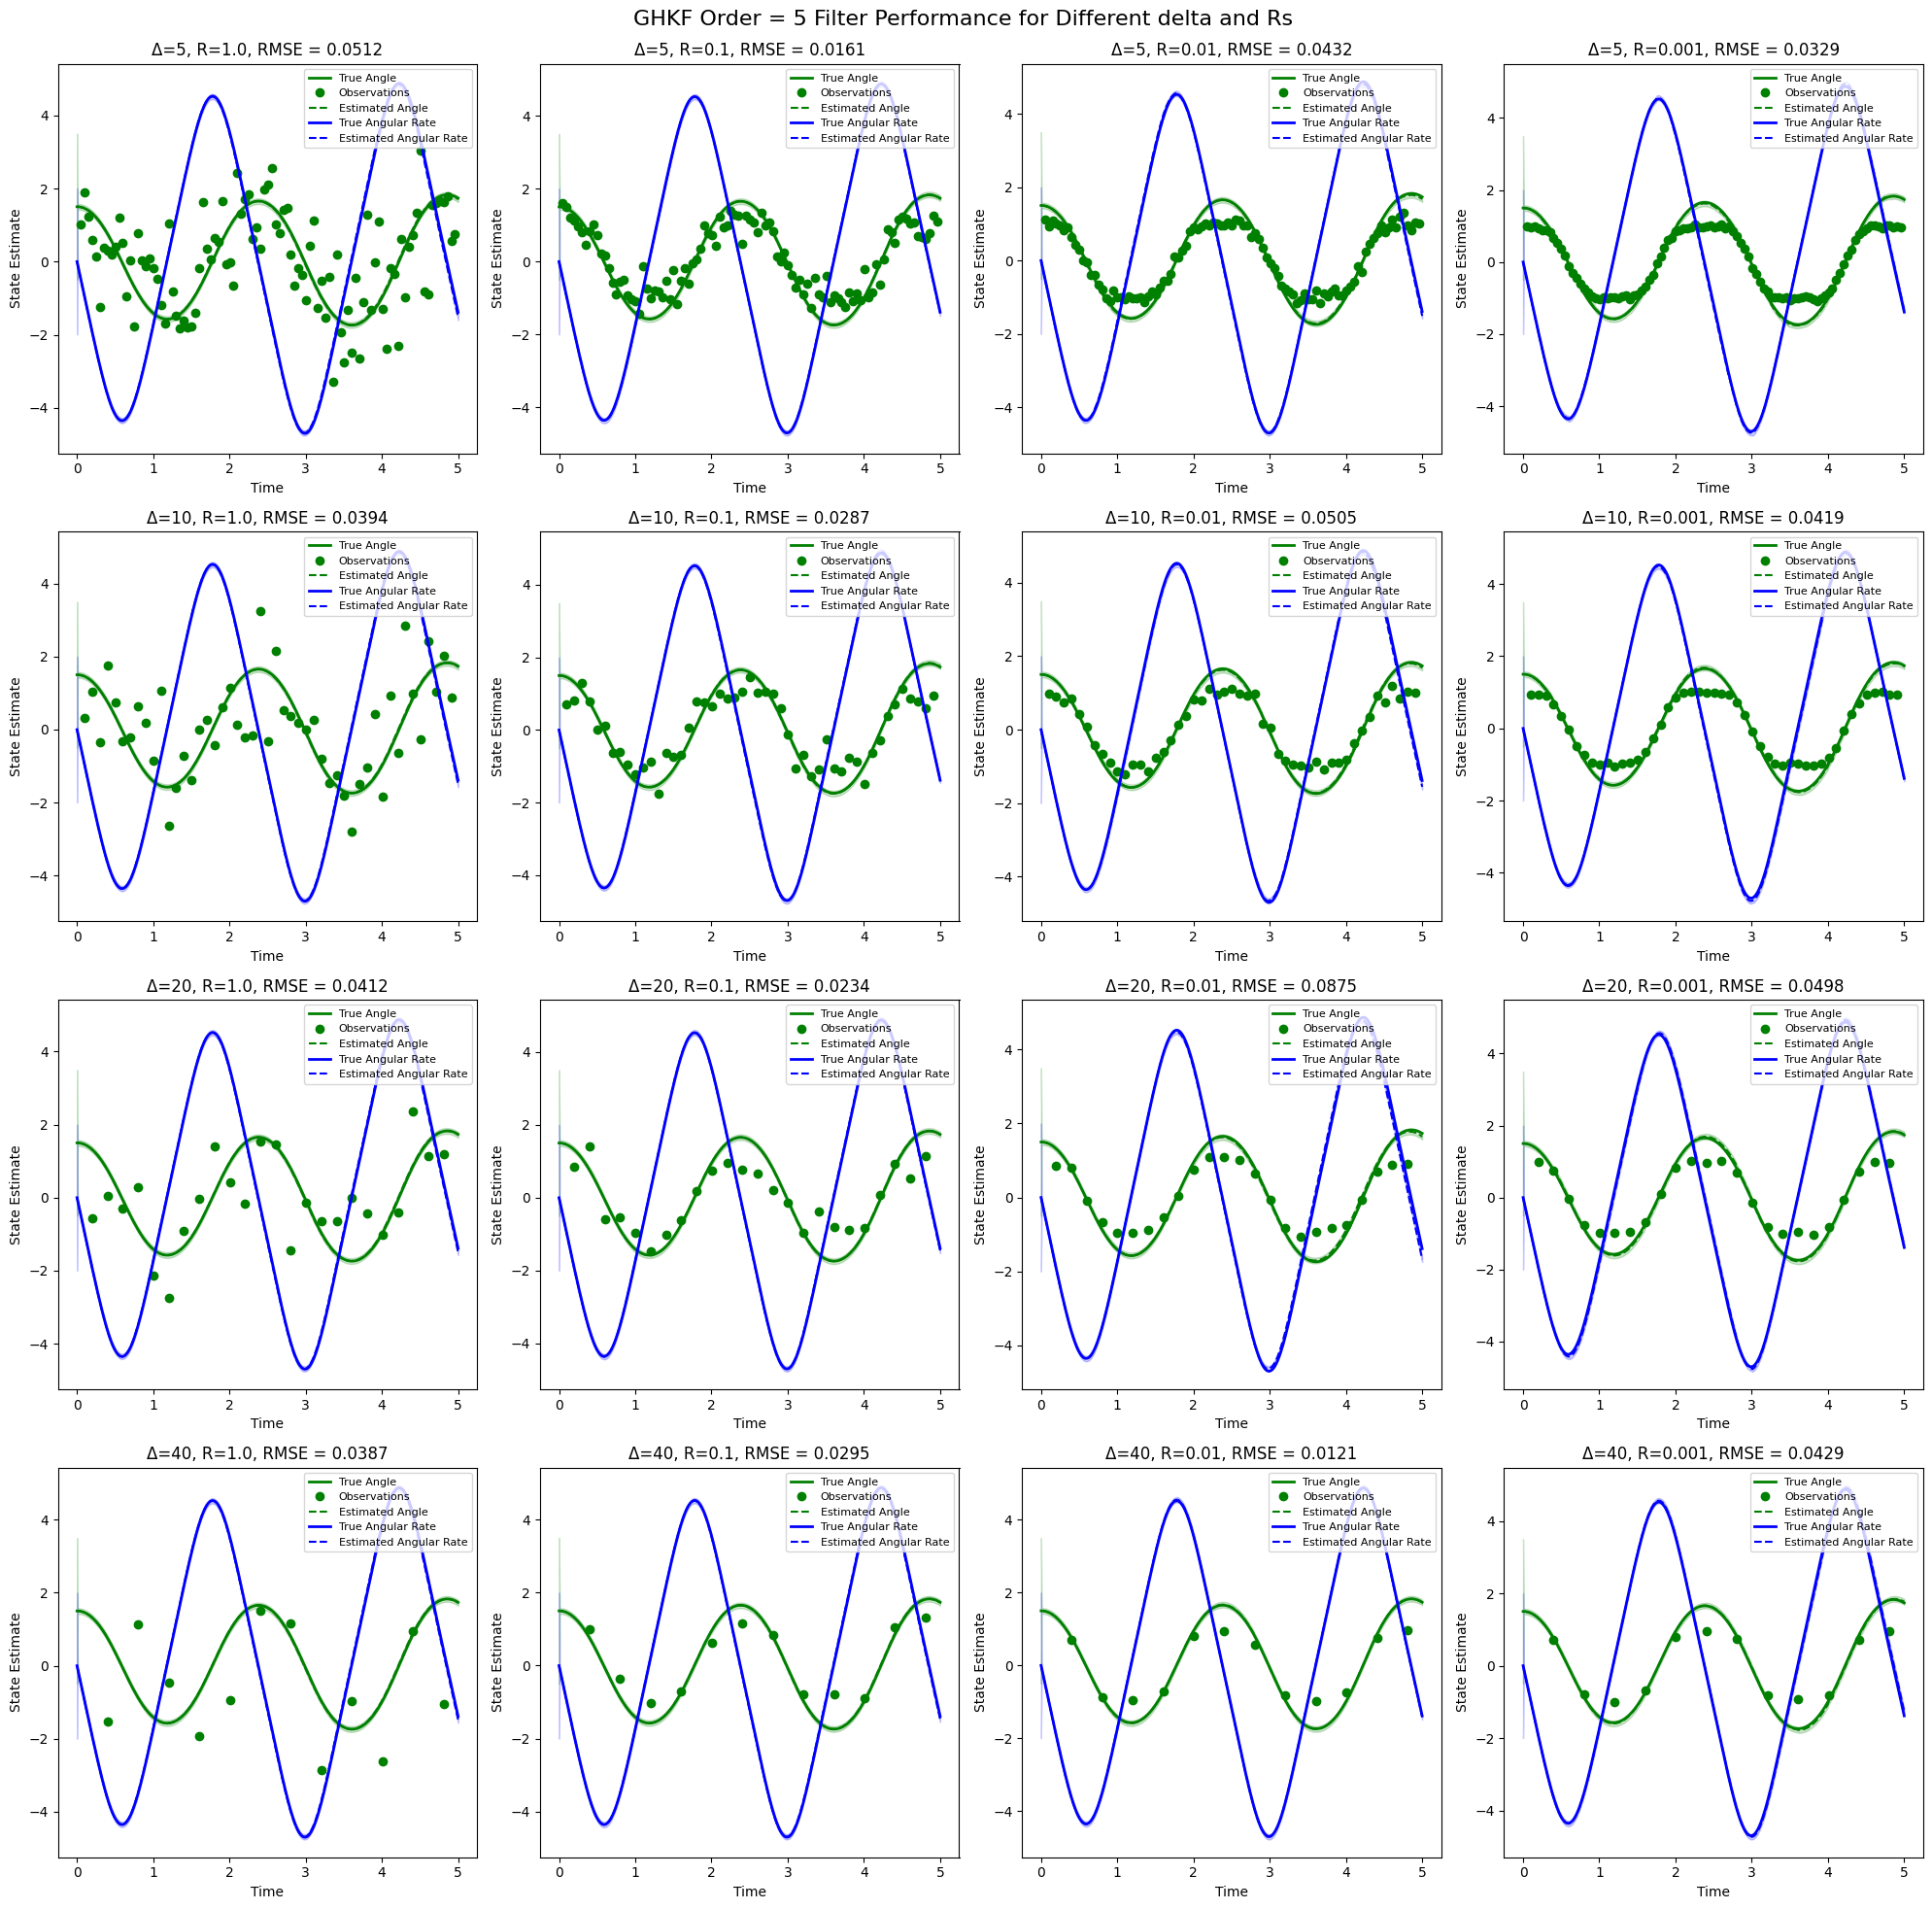

In [8]:
def plot_results(true_data, obs_data, kf_results, delta, R, ax):
    # Plot angle and angular rate
    ax.plot(true_data.times, true_data.obs[:, 0], 'g-', label='True Angle', linewidth=2)
    ax.plot(obs_data.times[obs_data.obs_ind], obs_data.obs, 'go', label='Observations')
    ax.plot(true_data.times, kf_results.means[:, 0], 'g--', label='Estimated Angle')
    ax.fill_between(true_data.times,
                    kf_results.means[:, 0] - 2*kf_results.stds[:, 0],
                    kf_results.means[:, 0] + 2*kf_results.stds[:, 0],
                    color='g', alpha=0.2)

    ax.plot(true_data.times, true_data.obs[:, 1], 'b-', label='True Angular Rate', linewidth=2)
    ax.plot(true_data.times, kf_results.means[:, 1], 'b--', label='Estimated Angular Rate')
    ax.fill_between(true_data.times,
                    kf_results.means[:, 1] - 2*kf_results.stds[:, 1],
                    kf_results.means[:, 1] + 2*kf_results.stds[:, 1],
                    color='b', alpha=0.2)

    RMSE = np.sqrt(np.mean((kf_results.means - true_data.obs)**2))

    ax.set_title(f"Δ={delta}, R={R}, RMSE = {np.round(RMSE, 4)}")
    ax.set_xlabel("Time")
    ax.set_ylabel("State Estimate")
    ax.legend(fontsize=8, loc='upper right')

# Parameters
dt = 0.01
N = 500
Tf = N * dt
x0 = np.array([1.5, 0.0])
q_c = 0.1

# UKF parameters
alpha = 1e-3
beta = 2.0
kappa = 0.2

# Values of delta and R
R_values = np.array([1, 0.1, 0.01, 0.001])
delta_values = np.array([5, 10, 20, 40])

# Initialize plot
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle("GHKF Order = 5 Filter Performance for Different delta and Rs \n", fontsize=16)
axes = axes.ravel()

# Iterate over delta and R
idx = 0
for delta in delta_values:
    for R in R_values:
        # Generate true and noisy data
        times = np.linspace(0, Tf, N)
        true_data, obs_data = generate_data(times, N, dt, delta, x0, R)

        # Set up UKF
        Q = np.array([[q_c * dt**3 / 3, q_c * dt**2 / 2], [q_c * dt**2 / 2, q_c * dt]])
        X = Gaussian(x0, np.eye(2))
        xi = Gaussian(np.zeros(2), Q)
        eta = Gaussian(0, R)
        order = 5

        # Run UKF
        kf_results = gauss_hermit_kalman_filter(obs_data, X, xi, eta, order)

        # Plot results in the corresponding subplot
        plot_results(true_data, obs_data, kf_results, delta, R, axes[idx])
        idx += 1

# Adjust layout
plt.tight_layout()
plt.show()